In [1]:
from os import chdir
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
chdir("/content/drive/MyDrive/Projet")

Mounted at /content/drive


In [2]:
import random
import pandas as pd
from os.path import join
from PIL import Image
import spacy

from torch import nn, device as torch_device, cuda, cat, tensor, tanh
from torch.nn.utils.rnn import pad_sequence
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F

In [3]:
# Load captions
PATH = "tutorial/flickr8k/"
captions = pd.read_csv(PATH+"/captions.txt")
captions.iloc[0:2]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


In [4]:
# Add <start> and <end> tags
captions.caption = captions.caption.apply(lambda x: f"<start> {x} <end>")
captions.iloc[0:2]

,image,caption
0,1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building . ...


In [5]:
# Shuffle images
images = captions.image.unique()
random.shuffle(images)
images

array(['3471841031_a949645ba8.jpg', '3506607642_40037b3fbf.jpg',
       '173020287_230bfc4ffc.jpg', ..., '2229177914_3308fe7d20.jpg',
       '3169276423_6918dd4da1.jpg', '3122888809_9ae9b4b9b2.jpg'],
      dtype=object)

In [6]:
# Select a subset of images for training
N = 1000
train_images = images[:N]

train_data = captions.loc[captions.image.isin(train_images)].reset_index(drop=True)
train_data.iloc[0:2]

,image,caption
0,1002674143_1b742ab4b8.jpg,<start> A little girl covered in paint sits in...
1,1002674143_1b742ab4b8.jpg,<start> A little girl is sitting in front of a...


<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>


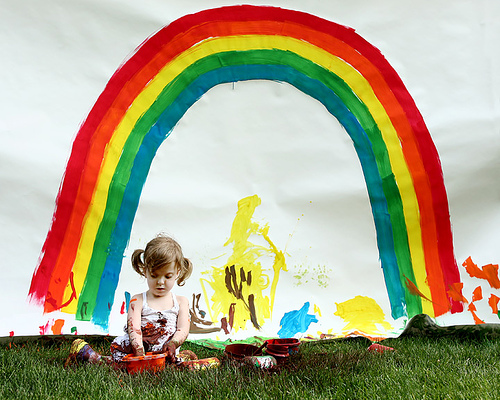

In [7]:
print(train_data.caption[0])
pic = Image.open(PATH +"Images/"+ train_data.image[0])
pic

In [8]:
class DatasetLoader(Dataset):

    def __init__(self, img_path, captions_file, normalise=False):
        self.img_path = img_path
        self.df = pd.read_csv(captions_file)
        
        self.normalise = normalise
        self.magic_mu = [0.485, 0.456, 0.406]
        self.magic_sigma = [0.229, 0.224, 0.225]
        
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.spacy_en = spacy.load('en_core_web_sm')
        self.word2idx = {"<START>": 0, "<END>": 1, "<UNK>": 2, "<PAD>": 3}
        self.idx2word = {i:w for w, i in self.word2idx.items()}

        self.transform = transforms.Compose([
            transforms.Resize((250, 250)),
            transforms.ToTensor()  # scale image to [0,1]
        ])


    def build_vocab(self):
        curr_idx = len(self.word2idx)
        freq_threshold = 2
        frequencies = dict()
        
        for sentence in self.captions:
            tokens = [str(token).lower() for token in self.spacy_en.tokenizer(sentence)]
            
            for tok in tokens:
                if tok in frequencies.keys():
                    frequencies[tok] += 1
                else:
                    frequencies[tok] = 1

                if frequencies[tok] == freq_threshold:
                    self.word2idx[tok] = curr_idx
                    self.idx2word[curr_idx] = tok
                    curr_idx += 1

    def tokenise(self, sentence):
        tokens = [str(token).lower() for token in self.spacy_en.tokenizer(sentence)]
        return [self.word2idx[tok] if tok in self.word2idx else self.word2idx["<UNK>"] for tok in tokens]
        
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        
        # Image
        img = Image.open(join(self.img_path, img_name))
        img = self.transform(img)

        if self.normalise:
            for c in range(3):
                img[c] -= self.magic_mu[c]
                img[c] /= self.magic_sigma[c]
        
        # Captions
        caption = tensor([self.word2idx["<START>"]] + self.tokenise(caption) + [self.word2idx["<END>"]])
        
        return img, caption

In [9]:
dataset = DatasetLoader(img_path=PATH+"Images/", captions_file=PATH+"captions.txt")
dataset.build_vocab()

In [10]:
def collate(batch, pad_idx):
    images = [item[0].unsqueeze(0) for item in batch]
    images = cat(images, dim=0)
    
    captions = [item[1] for item in batch]
    captions = pad_sequence(captions, batch_first=True, padding_value=pad_idx)
    return images, captions

In [11]:
collate_fn = lambda batch: collate(batch, dataset.word2idx["<PAD>"])

data_loader = DataLoader(
    dataset=dataset,
    batch_size=10,
    num_workers=2,
    shuffle=True,
    collate_fn=collate_fn
)

In [12]:
data_iter = iter(data_loader)
images, captions = next(data_iter)

# VGG

In [62]:
models.vgg16(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [147]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG16FeatureExtractor, self).__init__()

        model = models.vgg16(pretrained=True)

        # VGG-16 Feature Layers
        self.features = nn.Sequential(*list(model.features))

        # VGG-16 Average Pooling Layer
        self.pooling = model.avgpool

        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        
        # First part of fully-connected layer from VGG16
        self.fc = model.classifier[0]
        
    def forward(self, x):
        out = self.features(x)
        print("out1")
        print(out.shape)
        out = self.pooling(out)
        print(out.shape)

        #out = self.flatten(out)

        #out = self.fc(out) 

        
        return out 

In [148]:
device = torch_device('cuda:0' if cuda.is_available() else "cpu")
device = torch_device('cpu')
model = VGG16FeatureExtractor().to(device)

In [149]:
device

device(type='cpu')

In [150]:
model

VGG16FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pad

In [179]:
embed_dim = 242 # 2048 ???

In [180]:
class EncoderCNN(nn.Module):
    def __init__(self, cnn, embed_dim):
        super(EncoderCNN, self).__init__()
        
        self.cnn = cnn  # init pretrained CNN
        self.fc = nn.Linear(cnn.fc.out_features, embed_dim)


    def forward(self, images):
        # images shape: ..... (3,250,250)
        features = self.cnn.forward(images)  # images shape: (512, 7,7)        
       
        print("in fowardencode")
        #features = F.relu(features)

        features = features.permute(0,2,3,1)        # (7,7,512)
        features = features.view(features.size(0), -1, features.size(-1))  # (49,512)

        
        return features

In [181]:
encoder = EncoderCNN(model, embed_dim)


In [182]:
"""features = encoder.forward(images)"""

'features = encoder.forward(images)'

In [183]:
# features.shape

In [184]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, units):
        super(Attention, self).__init__()
        
        self.W1 = nn.Linear(encoder_dim, units)
        self.W2 = nn.Linear(decoder_dim, units)
        self.V = nn.Linear(units, 1)
    
    def forward(self, features, hidden_state):
        # features shape: (batch, 64, 256)

        # tanh scores
        scores = tanh(
            self.W1(features) + self.W2(hidden_state)
        ) # (batch, 64, units)
        scores = self.V(scores)  # (batch, 64, 1)
        # scores = scores.squeeze(2)
        
        attention = F.softmax(scores, dim=1)  # (batch, 64)
        # print("ok till here")
        context_vector = features * attention.unsqueeze(2)  # (batch, 64, 256)
        context_vector = context_vector.sum(dim=1)   # (batch, 64)
        
        return attention, context_vector

In [185]:
import torch

#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        # print("faetures")
        # print(features)
        # print(features.shape)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<START>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<END>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        # print("now i'm being seen")
        # print(mean_encoder_out)
        # print(mean_encoder_out.shape)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        # print("done init hidden")
        return h, c

In [186]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(model, embed_dim)
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.word2idx),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        
        features = self.encoder(images)
        # print("eliott")
        # print(features)
        # print(features.shape)
        outputs = self.decoder(features, captions)
        return outputs

In [187]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.word2idx)
attention_dim=256
encoder_dim=512
decoder_dim=512
learning_rate = 3e-4

In [188]:
import torch.optim as optim

#init model
encoder_decoder = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.word2idx),
    attention_dim=encoder_dim,
    encoder_dim=decoder_dim,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.word2idx["<PAD>"])
optimizer = optim.Adam(encoder_decoder.parameters(), lr=learning_rate)

In [189]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [190]:
num_epochs = 25
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = encoder_decoder(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                # show_image(img[0],title=caption)
                
            encoder_decoder.train()
        
    #save the latest model
    save_model(encoder_decoder,epoch)

out1
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 7, 7])
in fowardencode


RuntimeError: ignored